# Entrega Aplicando Conhecimento A2

Neste documento, que compõe a entrega necessária para o exercício A2 - Aplicando Conhecimento, os seguintes itens serão desenvolvidos:

1. Definição de linguagem de programação usada no Projeto
2. Análise exploratória da base de dados escolhida
3. Tratamento da base de dados 
4. Definição e descrição das bases teóricas dos métodos 
5. Definição e descrição de como será calculada a acurácia

## Definição de linguagem de programação usada no Projeto

Para o projeto, será utilizada a linguagem de programação Python, em virtude dos seguintes fatores:

1. Versatilidade: permite-se escrever tanto o backend quanto um REST API e frontend por meio de uma mesma linguagem, facilitando o desenvolvimento do protótipo;

2. Adequação à projetos de IA: python se tornou uma das linguagens naturalmente utilizadas para projetos envolvendo IA generativa, que é o caso deste trabalho;



## Tratamento da base de dados

Inicialmente, faz-se necessário ressaltar que a "base de dados" advém de um único documento com 179 páginas. Assim, para permitir uma análise exploratória ou qualquer outra atividade de análise, deve-se transformar o documento (dado não estruturado) em uma base de dados propriamente dita (no nosso caso, com a extração de pedaços - <i>chunks</i> - e transformação em vetores - por meio de modelos de <i>embeddings</i>).

Para isso, será utilizada a biblioteca opensource <b><a href='https://docling-project.github.io/docling/'>Docling</a></b>, que permite o processamento de textos em pdf com extração de imagens por OCR, além da biblioteca de IA generativa <a href='https://www.langchain.com/'>LangChain</a>, que permite a utilização de modelos de embeddings e de LLMs no trabalho. 

(Para maiores informações, acessar o website das bibliotecas).

A ideia da preparação de dados, neste caso, é permitir que o texto (dado não estruturado) seja transformado em um conjunto de vetores de valores (embeddings) para, posteriormente, ser usado por um sistema ou modelo para responder perguntas dos usuários.

#### Transformação do .pdf em um markdown

Através dessa transformação, o documento poderá ser posteriormente quebrado em seções, facilitando a criação de <i>chunks</i> para a criação da vector store. 



In [16]:
from docling.document_converter import DocumentConverter

source = "BalancoGeralEstadoRS.pdf"

converter = DocumentConverter()
result = converter.convert(source)

2025-10-02 22:14:26,098 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-10-02 22:14:26,103 - INFO - Going to convert document batch...
2025-10-02 22:14:26,103 - INFO - Initializing pipeline for StandardPdfPipeline with options hash e647edf348883bed75367b22fbe60347
2025-10-02 22:14:26,103 - INFO - Accelerator device: 'cuda:0'
2025-10-02 22:14:27,099 - INFO - Accelerator device: 'cuda:0'
2025-10-02 22:14:28,007 - INFO - Accelerator device: 'cuda:0'
2025-10-02 22:14:28,212 - INFO - Processing document BalancoGeralEstadoRS.pdf
2025-10-02 22:15:38,516 - INFO - Finished converting document BalancoGeralEstadoRS.pdf in 72.42 sec.


In [17]:
result.document.export_to_markdown()[:1000]

'<!-- image -->\n\n## Balanço Geral do Estado\n\nLivro I • Demonstrações Contábeis e Fiscais\n\n<!-- image -->\n\nGOVERNO DO ESTADO DO RIO GRANDE DO SUL SECRETARIA DA FAZENDA DO ESTADO CONTADORIA E AUDITORIA-GERAL DO ESTADO\n\n<!-- image -->\n\n| Eduardo Figueiredo Cavalheiro Leite Governador do Estado                  | EQUIPE TÉCNICA                                      |\n|---------------------------------------------------------------------------|-----------------------------------------------------|\n|                                                                           | Carina Trein Dinon                                  |\n| Pricilla Maria Santana Secretária de Estado da Fazenda                    | Claudio Teixeira Seelig Gabriela Machado dos Santos |\n| Itanielson Dantas Silveira Cruz                                           | Guilherme Speroni Lentz                             |\n| Secretário Adjunto da Fazenda                                             | João Batista

#### Transformação do markdown em chunks 

Após a transformação em markdown, permite-se que a biblioteca langchain consiga dividir o documento em chunks.

In [19]:
from langchain_text_splitters import MarkdownHeaderTextSplitter

headers_to_split_on = [
            ("#", "Header_1"),
            ("##", "Header_2"),
            ("###", "Header_3")
        ]

splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)

chunks = splitter.split_text(result.document.export_to_markdown())

chunks[50]


Document(metadata={'Header_2': '2.1.5.  Garantias e Contragarantias'}, page_content="Segundo a 14ª edição do MDF, garantia é 'o compromisso de adimplência de obrigação financeira ou contratual assumida pelo ente da Federação por ocasião da realização de operações de crédito por suas estatais não dependentes ou por outros entes da Federação'. Para a concessão de garantias, a LRF determina que sejam exigidas contragarantias em valor igual ou superior ao da garantia a ser concedida, oferecidas pelo ente recebedor da garantia, a fim de abranger o ressarcimento dos custos decorrentes de eventual inadimplemento.  \nA Resolução 43/2021 do Senado Federal estabeleceu que o saldo global das garantias concedidas pelos Estados, pelo DF e pelos Municípios não poderá exceder a 22% da RCL, podendo ser aumentado para 32% da RCL, caso o ente garantidor não tenha sido chamado a honrar, nos últimos 24 meses, quaisquer garantias anteriormente prestadas e esteja cumprindo os limites da dívida consolidada l

In [ ]:
print('O documento possui', len(chunks), 'chunks de tamanho médio', round(sum(len(chunk.page_content) for chunk in chunks) / len(chunks), 2), 'caracteres')

O documento possui 156 chunks de tamanho médio 3225.78 caracteres


#### Transformação dos chunks em vetores (embeddings)

Por fim, realiza-se a transformação dos chunks em vetores, e armazena-os para posterior utilização.

<i><b>Observação: para este tratamento, é necessário o uso de uma API key da OpenAI. Esta API KEY não estará disponível no repositório, sendo necessário criar um arquivo .env com a seguinte chave:

OPENAI_API_KEY: {chave_pessoal_da_openai}</b></i>


In [30]:
# Importação do modelo de embeddings
from langchain_openai import OpenAIEmbeddings
from dotenv import load_dotenv
from langchain_chroma import Chroma

load_dotenv()

# Configuração do modelo de embeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Criação da vector store
vector_store = Chroma.from_documents(
    documents=chunks,
    embedding=embeddings,
    persist_directory="vector_store"
)



2025-10-02 22:22:13,505 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Com isso, a Vector Store (que representa a base de dados) está pronta. 

## Análise Exploratória de Dados


### Entendimento dos dados

Conforme mencionado no arquivo "Projeto Aplicado II.pdf", os dados a serem utilizados são extraídos de um mesmo documento ("Balanço Geral do Estado do Rio Grande do Sul 2024").


In [31]:
print('O documento possui', len(chunks), 'chunks de tamanho médio', round(sum(len(chunk.page_content) for chunk in chunks) / len(chunks), 2), 'caracteres')

O documento possui 156 chunks de tamanho médio 3225.78 caracteres


Foram divididos em 156 chunks, representando possíveis 156 capítulos e/ou seções. 

Optou-se por criar um dataframe da biblioteca pandas para melhor explorar os dados. 

In [41]:
import pandas as pd 

estatisticas_chunks = pd.DataFrame(
    {
        'titulo': [chunk.metadata.values() for chunk in chunks],
        'tamanho': [len(chunk.page_content) for chunk in chunks],    # Extração de quantidade de caracteres
        'chunk': [chunk.page_content for chunk in chunks]
    }
)


In [42]:
estatisticas_chunks.sample(5)

,titulo,tamanho,chunk
39,(1.6.1. Pessoal e Encargos Sociais),3290,"Inicialmente, cabe ressaltar que, neste item, ..."
46,(2.1.1. Receita Corrente Líquida - RCL),4688,A RCL é o somatório das receitas de im...
150,(4.4.1. Movimentação Financeira dos Recursos ...,4787,A Movimentação Financeira dos Recursos Vi...
87,(3.4.2.1. Créditos Tributários a Receber - Aut...,583,Os créditos tributários constituídos na f...
35,(1.5.10. Alienação de Bens),1017,A tabela abaixo evidencia os valores nominais ...


In [43]:
estatisticas_chunks.sort_values(by='tamanho', ascending=False).head(10)

,titulo,tamanho,chunk
4,(SUMÁRIO),21473,| INTRODUÇÃO . . . . . . . . . . . ...
9,(QUADRO RESUMO DOS AJUSTES DECORRENTES DA CONS...,17211,| BALANÇO PATRIMONIAL CONSOLIDADO (Exclusões) ...
155,(ABREVIATURAS E SIGLAS),16984,```\nADCT Ato das Disposições Constitucionais ...
81,(3.3. PLANO DE IMPLANTAÇÃO DOS PROCEDIMENTOS C...,12928,A contabilidade pública brasileira está avança...
117,(3.5.3.1.1. Precatórios),10099,Os saldos de precatórios estão registrados em ...
79,(Em milhões de R$),9447,| ...
10,(BALANÇO ORÇAMENTÁRIO CONSOLIDADO - ORÇAMENTOS...,8836,| RECEITAS ORÇAMENTÁRIAS ...
147,(4.2. BALANÇO FINANCEIRO),8815,| ...
47,(2.1.2. Despesa com Pessoal),8607,O Demonstrativo da Despesa com Pessoal é parte...
2,(MENSAGEM DA SECRETÁRIA),8396,Este Balanço Geral do Estado cumpre a finalida...


In [44]:
estatisticas_chunks.tamanho.describe()

count      156.000000
mean      3225.782051
std       3239.752954
min         14.000000
25%       1155.000000
50%       2248.000000
75%       4390.000000
max      21473.000000
Name: tamanho, dtype: float64

Percebe-se acima que há muitos chunks com elevada quantidade de caracteres, em especial o Sumário.
Além disso, chama a atenção um chunk com 14 caracteres.

In [46]:
estatisticas_chunks.query('tamanho < 1000').head(5)

,titulo,tamanho,chunk
0,(),14,<!-- image -->
8,(3. Consolidação das Demonstrações Contábeis),207,A consolidação dos balanços e demonstrativos d...
12,(1.1.2. Execução de Restos a Pagar),322,Além dos pagamentos das despesas empenhadas e ...
16,(1.2. PLANEJAMENTO),458,O planejamento estatal é formalizado com base ...
18,(1.2.2. Lei de Diretrizes Orçamentárias (LDO)),995,A Lei de Diretrizes Orçamentárias (LDO) é o in...


Como esperado, o chunk de 14 caracteres era uma imagem que acabou não sendo processada. Observando manualmente o Balanço Geral, contudo, percebeu-se ser só uma imagem figurativa, sem valor para o trabalho.

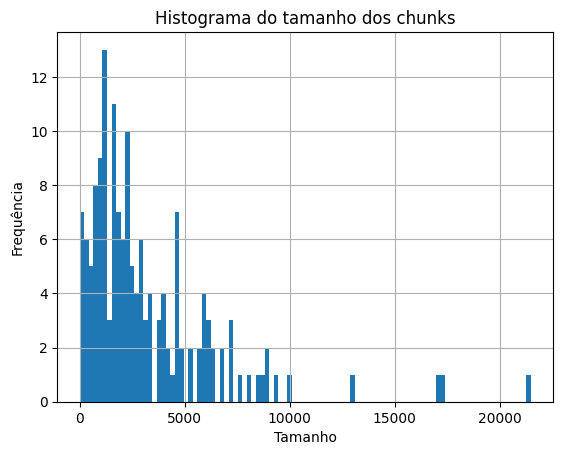

In [57]:
import matplotlib.pyplot as plt

estatisticas_chunks.tamanho.hist(bins=100)
plt.title('Histograma do tamanho dos chunks')
plt.xlabel('Tamanho')
plt.ylabel('Frequência')
plt.show()



Analisando a frequência das palavras, verifiquemos as mais frequentes nos chunks e em geral.

In [64]:
from collections import Counter
import re

def extrair_palavras_mais_frequentes(texto, n=10):
    texto = texto.lower()
    texto = re.sub(r'[^a-záéíóúàâêôãõç\s]', '', texto)
    palavras = texto.split()
    stopwords = {"a", "o", "e", "de", "do", "da", "em", "um", "uma", "que", "para", 
                 "no", "na", "os", "as", "com", "por", "se", "ao", "dos", "das"}
    palavras_filtradas = [p for p in palavras if p not in stopwords]
    contagem = Counter(palavras_filtradas)
    
    return contagem.most_common(n)


for idx, row in estatisticas_chunks.iterrows():
    palavras = extrair_palavras_mais_frequentes(row['chunk'])
    estatisticas_chunks.at[idx, 'palavras_mais_frequentes'] = palavras

textao = ' '.join([chunk for chunk in estatisticas_chunks.chunk])
palavras_mais_frequentes = extrair_palavras_mais_frequentes(textao, n=100)

In [65]:
palavras_mais_frequentes

[('r', 573),
 ('estado', 316),
 ('milhões', 312),
 ('não', 228),
 ('dívida', 194),
 ('total', 188),
 ('despesas', 181),
 ('recursos', 181),
 ('à', 159),
 ('prazo', 154),
 ('valor', 149),
 ('transferências', 143),
 ('lei', 139),
 ('é', 136),
 ('exercício', 132),
 ('pelo', 128),
 ('fundo', 128),
 ('receitas', 125),
 ('estadual', 121),
 ('bilhões', 119),
 ('receita', 113),
 ('ou', 112),
 ('outras', 110),
 ('valores', 109),
 ('despesa', 108),
 ('pela', 105),
 ('foi', 104),
 ('como', 102),
 ('são', 97),
 ('saldo', 96),
 ('caixa', 95),
 ('financeiro', 94),
 ('seguir', 94),
 ('pagar', 93),
 ('conforme', 90),
 ('créditos', 88),
 ('ativa', 86),
 ('ser', 85),
 ('saúde', 84),
 ('grande', 82),
 ('pessoal', 82),
 ('vinculados', 80),
 ('outros', 79),
 ('i', 77),
 ('longo', 76),
 ('plano', 75),
 ('pública', 74),
 ('aos', 74),
 ('curto', 74),
 ('rio', 73),
 ('resultado', 73),
 ('administração', 72),
 ('precatórios', 72),
 ('contribuições', 72),
 ('líquida', 71),
 ('ii', 71),
 ('var', 70),
 ('patrimoni

## Definição e descrição das bases teóricas dos métodos 

### Engenharia de Dados

A **Engenharia de Dados** é uma disciplina que se concentra no design, construção e manutenção de sistemas de dados robustos e escaláveis. Ela envolve, entre outros conceitos:

- **Pipeline de Dados**: Sequência de processos que extraem, transformam e carregam dados (ETL/ELT)
- **Arquitetura de Dados**: Estrutura organizacional que define como os dados fluem através de um sistema
- **Data Lake**: Repositório que armazena dados brutos em seu formato nativo


#### <i>Relação do trabalho com a disciplina

No caso do trabalho em questão, utilizou-se um pipeline básico com as bibliotecas docling e langchain para construir um equivalente a um Data Lake, aqui chamado de Vector Store, com uma arquitetura voltada para a utilização na modelagem e implementação do sistema baseado em LLM.</i>




### Inteligência Artificial (IA)

A **Inteligência Artificial** é um campo da ciência da computação que visa criar sistemas capazes de realizar tarefas que normalmente requerem inteligência humana:

- **Machine Learning (ML)**: Algoritmos que aprendem padrões a partir de dados sem programação explícita
- **Deep Learning**: Subcampo do ML que usa redes neurais com múltiplas camadas
- **Processamento de Linguagem Natural (NLP)**: Capacidade de máquinas entenderem e processarem linguagem humana
- **Computer Vision**: Capacidade de máquinas interpretarem e analisarem informações visuais
- **Sistemas de Recomendação**: Algoritmos que sugerem itens relevantes para usuários
- **IA Generativa**: Modelos que podem criar conteúdo novo (texto, imagens, código) baseado em padrões aprendidos


#### <i> Relação do trabalho com a disciplina

No caso deste trabalho, utilizou-se ferramentas de visão computacional e de machine learning, tornadas abstradas na biblioteca docling, de processamento de linguagem natural (para exploração dos dados e embeddings), além de planejar o uso de IA generativa para os próximos passos.</i>


### Processamento de Dados Não Estruturados

**Dados não estruturados** são informações que não seguem um formato predefinido ou modelo de dados específico:

- **Textos**: Documentos, emails, posts em redes sociais, artigos
- **Imagens**: Fotos, diagramas, gráficos, documentos digitalizados
- **Áudio**: Gravações de voz, música, podcasts
- **Vídeo**: Gravações, transmissões ao vivo, conteúdo multimídia
- **Dados Semi-estruturados**: JSON, XML, logs de sistema

**Técnicas de Processamento**:
- **OCR (Optical Character Recognition)**: Conversão de imagens com texto em texto editável
- **Web Scraping**: Extração automatizada de dados de websites
- **Análise de Sentimento**: Determinação da opinião ou emoção em textos
- **Extração de Entidades**: Identificação de pessoas, lugares, organizações em textos
- **Embeddings**: Representação vetorial de textos para análise semântica

#### <i>Relação do trabalho com a disciplina

Conforme já mencionado, a biblioteca Docling utiliza em seu baixo nível instrumentos de OCR e outras técnicas para a transformação dos dados não estruturados. O resultado se torna equivalente a dados semi-estruturados, aptos a receberem uma representação vetorial (embeddings). </i>



### Tópicos de Banco de Dados

Os **Bancos de Dados** são sistemas organizados para armazenar, gerenciar e recuperar informações:

#### **Bancos Relacionais (SQL)**:
- **ACID**: Atomicidade, Consistência, Isolamento, Durabilidade
- **Normalização**: Processo de organização de dados para reduzir redundância
- **Índices**: Estruturas que aceleram consultas
- **Transações**: Operações que mantêm integridade dos dados
- **Views**: Representações virtuais de dados

#### **Bancos NoSQL**:
- **Documentos**: MongoDB, CouchDB (armazenam documentos JSON/BSON)
- **Chave-Valor**: Redis, DynamoDB (armazenam pares chave-valor)
- **Colunas**: Cassandra, HBase (armazenam dados em colunas)
- **Grafos**: Neo4j, Amazon Neptune (armazenam relacionamentos)

#### **Conceitos Avançados**:
- **Data Warehousing**: Repositórios otimizados para análise
- **Data Mining**: Descoberta de padrões em grandes volumes de dados
- **OLAP vs OLTP**: Processamento analítico vs transacional
- **Sharding**: Divisão de dados em múltiplos servidores
- **Replicação**: Cópias de dados para alta disponibilidade
- **Backup e Recovery**: Estratégias de proteção e recuperação de dados



### Resumo da Integração das Disciplinas no Projeto

Este projeto integra todas essas áreas ao:
1. **Processar dados não estruturados** (PDF) usando técnicas de NLP e OCR
2. **Aplicar IA** através de embeddings e modelos de linguagem para análise semântica
3. **Utilizar conceitos de banco de dados** na criação de vector stores para busca eficiente
4. **Implementar engenharia de dados** no pipeline de transformação e armazenamento dos dados


## Definição e descrição de como será calculada a acurácia

O trabalho possui como desafio <i>"tornar informações complexas e densas compreensíveis e úteis para o cidadão comum, fortalecendo o exercício do controle social e promovendo uma gestão pública mais aberta e participativa" </i> (Projeto Aplicado II, p. 8).

Isso foi reescrito no objetivo de criar <i>"um  ChatBOT  interativo,  capaz  de interpretar o Balanço Geral do Estado e demais documentos oficiais, respondendo a consultas  de  usuários sem recorrer  a  terminologia  técnica, de  forma clara e contextualizada."</i> (Projeto Aplicado II, p. 8).

Uma métrica para o cálculo da acurácia, então, deve levar em conta esse objetivo.


A despeito do termo acurácia não ser o melhor conceito a ser aplicado ao projeto, propõe-se que a métrica de avaliação seja a seguir:

<i><b>Compreensividade</b></i>: quantidade de respostas que puderam ser compreendidas pelos usuários em relação ao total.


Por ser uma métrica de custo elevado de obtenção (dado que não será fácil obter respostas de usuários finais, em especial daqueles que não possuem contato direto com códigos - tecnologia - nem com a matéria contábil), propõe-se a utilização de um <i>proxy</i>:

<i><b>Compreensividade Artificial</b</i>: quantidade de respostas que puderam ser compreendidas por LLMs com prompts delimitantes em relação ao toal.


Neste caso, <i>prompt delimitante</i> é um prompt que atribui uma personalidade para a LLM e restringe expressamente as respostas e o entendimento baseado no nível de conhecimento esperado daquela personalidade. Por exemplo:


Prompt Estruturante de Enfermeiro:

" Você é um ator artístico dedicado. Seu objetivo é representar fielmente um papel de uma pessoa, a fim de que conseguir expressar qual seria a reação dessa pessoa a uma determinada informação.

Restrinja seu entendimento sobre a resposta e em relação ao mundo ao que seria esperado de uma pessoa na mesma situação a que te for dada. Não fuja desta ordem.

Você receberá um papel e deverá dar feedback a uma determinada frase/texto, retornando uma avaliação de 1 a 5 de compreensividade e a justificativa, conforme os graus a seguir:

1. Não compreendeu nada;
2. Texto de difícil compreensão
3. Texto normal, é capaz de entender 
4. Texto relativamente adequado ao seu conhecimento
5. Texto perfeitamente compreendido por ter usado termos usuais no seu dia a dia

Exemplos:

Papel: Seu nome é Amanda Sardinha, você é enfermeira no Hospital Central do Rio Grande do Sul. Você nunca teve contato com linguagem de programação nem com qualquer outra matéria que não fosse relacionada a sua vida profissional. Você gosta de correr e ver séries, e sai com os amigos para balada.

Texto: "O crescimento da dívida com a União se deve ao esquema de postergação e refinanciamento  parcial  das  parcelas  possibilitado  pelo  Regime  de  Recuperação  Fiscal  (RRF)  e, sobretudo, à correção monetária do saldo devedor pelo CAM (coeficiente de atualização monetária),  utilizada  para  corrigir  o  saldo  devedor  até  o  mês  de  junho.  A  partir  de  julho, com a entrada em vigor da LC 206/2024, o saldo devedor passou a ser atualizado pelo IPCA. Além disso, a LC 206/2024 suspendeu o pagamento da dívida com a União por 36 meses e  determinou  juro  zerado  nesse  período.  Ao  fim  do  período  previsto,  pela  regra  atual, a atualização do saldo devedor voltará a ser realizada por meio da CAM"

Feedback: {"compreensividade": 1, "justificativa": "Eu, como Amanda, não compreendo o que seja Regime de Recuperação Fiscal, nem o que seria LC. Além disso, o texto é confuso para mim."}


Papel: Seu nome é Amanda Sardinha, você é enfermeira no Hospital Central do Rio Grande do Sul. Você nunca teve contato com linguagem de programação nem com qualquer outra matéria que não fosse relacionada a sua vida profissional. Você gosta de correr e ver séries, e sai com os amigos para balada.

Texto: "A dívida do Estado com o resto do Brasil (União) foi sendo postergada e refinanciada, e aumentou à cada refinanciamento por causa da aplicação de juros e correção monetária por um índice específico (CAM) até junho. Em julho, entrou uma lei que permitiu que a correção monetária fosse feita usando outro índice (IPCA), além de outra lei ter suspendido os pagamentos por 36 meses, com juros zeros enquanto durasse a suspensão. Ao final desse período, os juros vão voltar a ser calculados pelo índice inicial (CAM)."

Feedback: {"compreensividade": 3, "justificativa": "Eu, como Amanda, pude compreender que o Estado está em dívida com a União e que houve uma mudança da forma de calcular os juros no período. Mas ainda resta confuso sobre o que isso significa na prática."}

"



A despeito do proxy não ser perfeito, é uma forma de mensurar quando o sistema estiver razoavelmente pronto para uma anotação mais cara (utilização de usuários finais). A expectativa é que seja montado um dataset de avaliação, contendo diversas perguntas sobre o balanço, e que cada uma das respostas tenha avaliação de 5 a 10 personalidades distintas, obtendo-se a métrica (Compreensividade Artificial) pela média das notas. 



